<a href="https://colab.research.google.com/github/BenRyan-8/US_Gas_Prices_Analysis/blob/main/NonSeasonal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Nonseasonal Time Series Analysis


> Ben Ryan - C22513316

> Abdolhmed Bashara - C22406056





##US Gasoline Retail Price 1995-2021

> Source: U.S. Energy Information Administration (Jan 2021).






###Dataset Overview:
The dataset comprises weekly U.S. All Grades All Formulations Retail Gasoline Prices in Dollars per Gallon. It provides a time series of retail gasoline prices across the United States.
This dataset offers insights into the dynamics of U.S. retail gasoline prices, crucial for understanding market trends and informing decision-making processes.

Import necessary libraries

In [40]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


Import data

In [41]:
data_url= 'https://raw.githubusercontent.com/BenRyan-8/US_Gas_Prices_Analysis/main/PET_PRI_GND_DCUS_NUS_W.csv'
df = pd.read_csv(data_url)

df.head()

,Date,Data
0,01/02/1995,1.127
1,01/09/1995,1.134
2,01/16/1995,1.126
3,01/23/1995,1.132
4,01/30/1995,1.131


Present Data

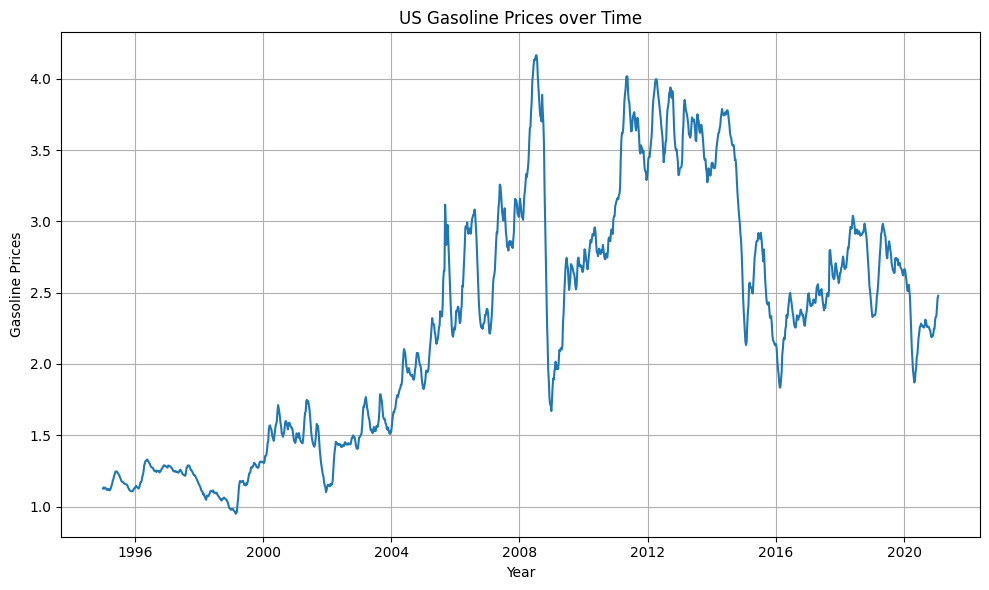

In [42]:
# Convert Date column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Data'])

plt.title('US Gasoline Prices over Time')
plt.xlabel('Year')
plt.ylabel('Gasoline Prices')
plt.grid(True)
plt.tight_layout()

plt.savefig('figures/fig1_USGP.png', dpi=1000)

Stationarity test

In [43]:
from statsmodels.tsa.stattools import adfuller

ADF_result = adfuller(df['Data'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -2.5478030071370674
p-value: 0.10427218376736413


Apply Differencing

In [44]:
gas_diff = np.diff(df['Data'], n=1)

ADF_result = adfuller(gas_diff)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')


ADF Statistic: -10.96196040254643
p-value: 8.283067090030382e-20


Visualise stationarity

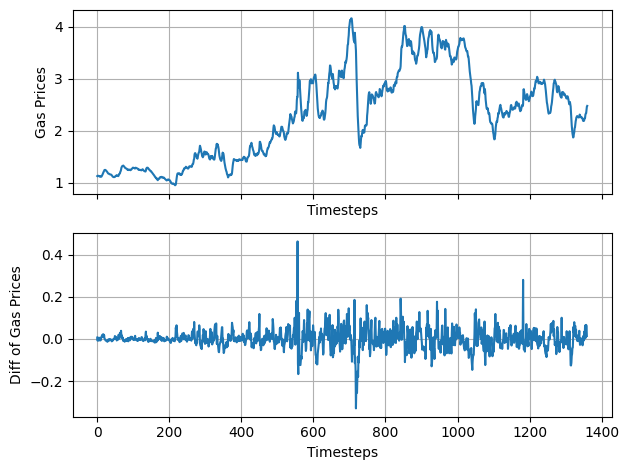

In [45]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

ax1.plot(df['Data'])
ax1.set_xlabel('Timesteps')
ax1.set_ylabel('Gas Prices')
ax1.grid(True)

ax2.plot(gas_diff)
ax2.set_xlabel('Timesteps')
ax2.set_ylabel('Diff of Gas Prices')
plt.grid(True)

plt.tight_layout()

plt.savefig('figures/fig2_USGP.png', dpi=1000)

Is it Moving Average?

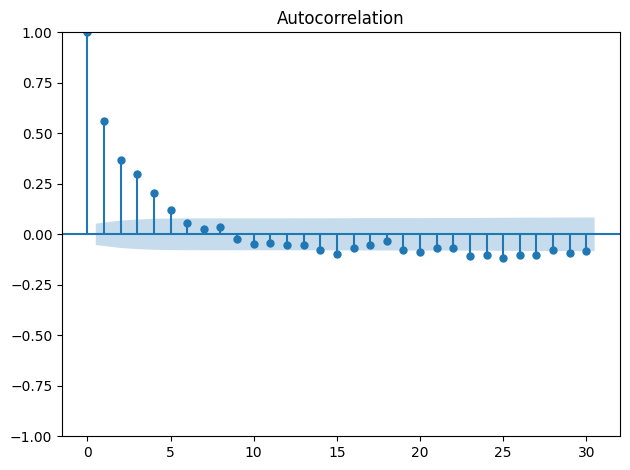

In [46]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(gas_diff, lags=30);
plt.tight_layout()

plt.savefig('figures/fig3_USGP.png', dpi=300)

Is it Auto-Regression?

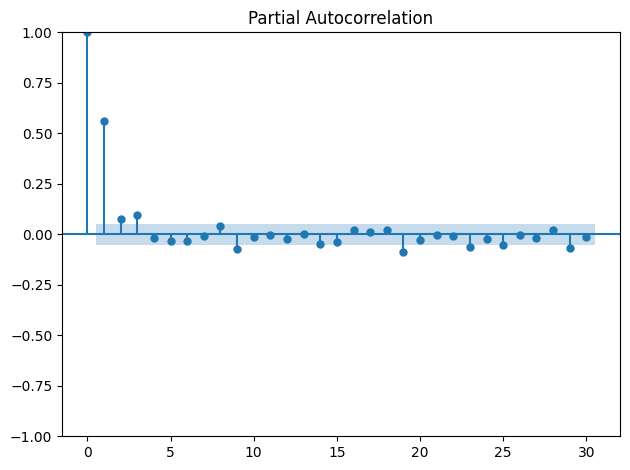

In [47]:
plot_pacf(gas_diff, lags=30);
plt.tight_layout()

plt.savefig('figures/fig4_USGP.png', dpi=300)

Split data to be trained and tested

In [48]:
df_diff = pd.DataFrame({'gas_prices_diff': gas_diff})

train = df_diff[:1250]
test = df_diff[1250:]

print(len(train))
print(len(test))

1250
110


Visualise the data being tested

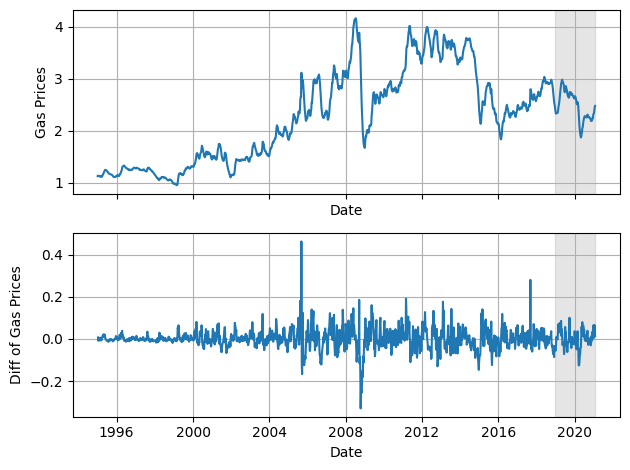

In [49]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

ax1.plot(df['Date'], df['Data'])
ax1.set_xlabel('Date')
ax1.set_ylabel('Gas Prices')
ax1.grid(True)

ax1.axvspan(df['Date'].iloc[1250], df['Date'].iloc[-1], color='#808080', alpha=0.2)


ax2.plot(df.loc[1:,['Date']], gas_diff)
ax2.set_xlabel('Date')
ax2.set_ylabel('Diff of Gas Prices')
plt.grid(True)

ax2.axvspan(df['Date'].iloc[1250], df['Date'].iloc[-1], color='#808080', alpha=0.2)


plt.tight_layout()

plt.savefig('figures/fig4_USGP.png', dpi=1000)

###AR(3)

In [50]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess

l=len(train)
ts=df['Data']
model=SARIMAX(train, order=(3,0,0))
res = model.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:        gas_prices_diff   No. Observations:                 1250
Model:               SARIMAX(3, 0, 0)   Log Likelihood                2228.010
Date:                Mon, 29 Apr 2024   AIC                          -4448.020
Time:                        15:06:28   BIC                          -4427.497
Sample:                             0   HQIC                         -4440.305
                               - 1250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5072      0.011     47.669      0.000       0.486       0.528
ar.L2          0.0203      0.018      1.156      0.248      -0.014       0.055
ar.L3          0.1030      0.019      5.544      0.0

Rolling Forecast is applied of AR(3)

In [51]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:

    total_len = train_len + horizon
    end_idx = train_len

    if method == 'mean':
        pred_mean = []

        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []

        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))

        return pred_last_value

    elif method == 'AR':
        pred_AR = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(3,0,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)

        return pred_AR

In [52]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_AR = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'AR')

test['pred_mean'] = pred_mean
test['pred_last_value'] = pred_last_value
test['pred_AR'] = pred_AR

test.head()

,gas_prices_diff,pred_mean,pred_last_value,pred_AR
1250,-0.047,0.001066,-0.051,-0.035397
1251,-0.055,0.001028,-0.047,-0.028283
1252,-0.029,0.000983,-0.055,-0.034152
1253,0.009,0.000959,-0.029,-0.020699
1254,0.002,0.000966,0.009,-0.001684


Present findings and forecasts of differenced data

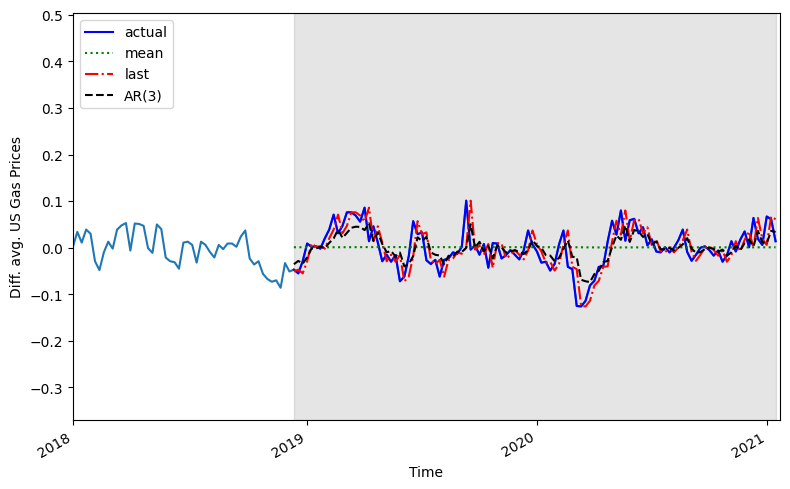

In [57]:
fig, ax = plt.subplots(figsize=(8,5))

ax.plot(df_diff['gas_prices_diff'])
ax.plot(test['gas_prices_diff'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_value'], 'r-.', label='last')
ax.plot(test['pred_AR'], 'k--', label='AR(3)')

ax.legend(loc=2)
#1250+110,1360
ax.set_xlabel('Time')
ax.set_ylabel('Diff. avg. US Gas Prices')

ax.axvspan(1250, 1359, color='#808080', alpha=0.2)

ax.set_xlim(1200, 1360)

plt.xticks([1200, 1253, 1305, 1357],[2018, 2019, 2020, 2021])

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH05_F10_peixeiro.png', dpi=300)

Evaluate the effectivesness of the model

In [58]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test['gas_prices_diff'], test['pred_mean'])
mse_last = mean_squared_error(test['gas_prices_diff'], test['pred_last_value'])
mse_AR = mean_squared_error(test['gas_prices_diff'], test['pred_AR'])

print(mse_mean, mse_last, mse_AR)

0.0017930639805121443 0.0011394454545454508 0.0009800892759790642


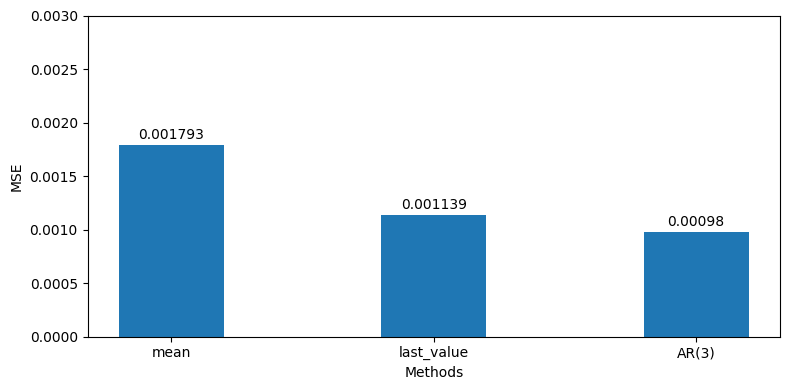

In [64]:
fig, ax = plt.subplots(figsize=(8,4))

x = ['mean', 'last_value', 'AR(3)']
y = [mse_mean, mse_last, mse_AR]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 0.003)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.00005, s=str(round(value, 6)), ha='center')

plt.tight_layout()

Forecast actual data

In [65]:
df['pred_gas_prices'] = pd.Series()
df['pred_gas_prices'][1251:] = df['Data'].iloc[1251] + test['pred_AR'].cumsum()

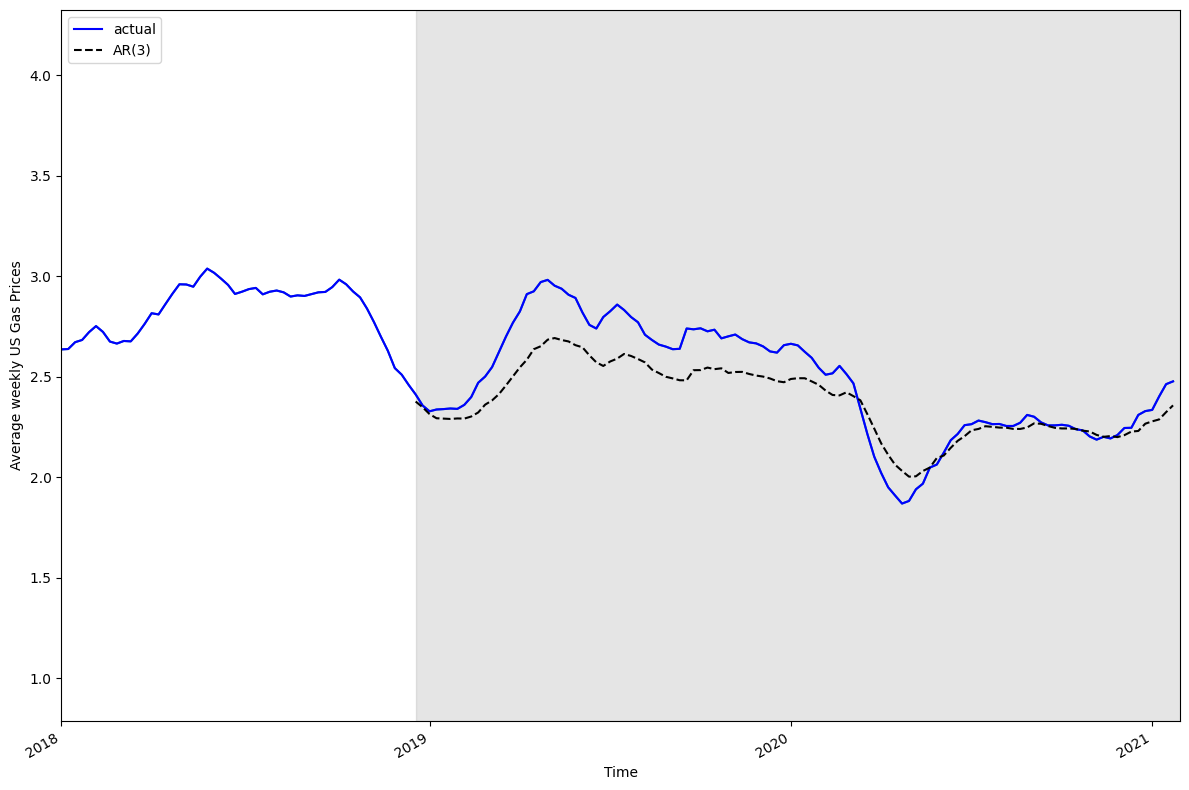

In [66]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(df['Data'])
ax.plot(df['Data'], 'b-', label='actual')
ax.plot(df['pred_gas_prices'], 'k--', label='AR(3)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Average weekly US Gas Prices')

ax.axvspan(1251, 1362, color='#808080', alpha=0.2)

ax.set_xlim(1200, 1361)
#ax.set_ylim(650, 770)

plt.xticks([1200, 1253, 1305, 1357],[2018, 2019, 2020, 2021])

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH05_F11_peixeiro.png', dpi=300)

Evaluation on actual scale

In [67]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

mae_AR_undiff = mean_absolute_error(df['Data'][1251:], df['pred_gas_prices'][1251:])
mape_AR_undiff = mean_absolute_percentage_error(df['Data'][1251:], df['pred_gas_prices'][1251:])

print('MAE:', "%.2f" % mae_AR_undiff)
print('MAPE:',"%.2f" % (mape_AR_undiff*100),'%')

MAE: 0.12
MAPE: 4.54 %
